In [2]:
%matplotlib inline

from math import *
import matplotlib
import numpy as np
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pylab
from scipy import interpolate
import os
text_size=26
fig_size_x=24
fig_size_y=14
import seaborn as sns
Colors = sns.color_palette("viridis", 16).as_hex()
from collections import defaultdict

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data_kgb = nested_dict(5, list)
data_kev = nested_dict(5, list)

In [3]:
import os

# Where to save the figures

IMAGES_PATH = './images'
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=180):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

# PYTHON WRAPPER hiclass

In [19]:
from configparser import ConfigParser
from itertools import chain

folder_name_kev = '../k-evolution_devel-k-evolution-/imp'
folder_name_kgb = './data/2048-1500Mpc'
#folder_name_kgb = './imp'
#folder_name_kgb300 = './imp300'
#folder_name = 'imp'

parser = ConfigParser()
with open(f"./../{folder_name_kgb}/file_classparameters.ini") as lines:
    lines = chain(("[top]",), lines) # This line produce a fake section header called top
    parser.read_file(lines)

h = float(parser.get("top", "h"))
Omega_b = float(parser.get("top", "Omega_b"))
Omega_cdm = float(parser.get("top", "Omega_cdm"))
#m_ncdm = float(parser.get("top", "m_ncdm"))
n_s = float(parser.get("top", "n_s"))
A_s = float(parser.get("top", "A_s"))
gravity_model = (parser.get("top", "gravity_model"))

#Omega_smg = float(parser.get("top", "Omega_smg"))
Omega_Lambda = float(parser.get("top", "Omega_Lambda"))
Omega_fld = float(parser.get("top", "Omega_fld"))

# Extract and parse the 'parameters_smg' string
parameters_smg_str = parser.get("top", "parameters_smg")
parameters_smg_list = parameters_smg_str.split(',')



if len(parameters_smg_list) < 2:
    raise ValueError("parameters_smg must contain at least two values: alpha_k and alpha_b.")

# Convert the first two parameters to floats
alpha_K_hat = float(parameters_smg_list[0].strip())
alpha_B_hat = float(parameters_smg_list[1].strip())


# Extract and parse the 'parameters_smg' string
expansion_smg_str = parser.get("top", "expansion_smg")
expansion_smg_list = expansion_smg_str.split(',')

Omega_smg = float(expansion_smg_list[0].strip())
w0 = float(expansion_smg_list[1].strip())
wa = float(expansion_smg_list[2].strip())

# Function to format numbers for LaTeX (reusing the previous function)
def format_scientific_latex(number):
    mantissa, exponent = f"{number:.1e}".split('e')
    exponent = exponent.lstrip('+').lstrip('0') or '0'
    return f"{mantissa} \\times 10^{{{exponent}}}"

# Format the alpha values
alpha_K_hat_latex = format_scientific_latex(alpha_K_hat)

# reading the redshifts

z = []

with open(f'./../{folder_name_kgb}/file_settings_used.ini', 'r') as f:
    for line in f:
        if line.startswith('Pk redshifts'):
            # Extract the part after '=' and split by commas
            redshifts_string = line.split('=')[1].split('#')[0].strip()  # Remove comments after #
            z = [float(x.strip()) for x in redshifts_string.split(',')]  # Parse as floats
            
with open(f"./../{folder_name_kgb}/file_settings_used.ini") as lines:
    lines = chain(("[top]",), lines) # This line produce a fake section header called top
    parser.read_file(lines)


boxsize = float(parser.get("top", "boxsize"))
Ngrid = float(parser.get("top", "Ngrid"))

k_nyq = np.pi*Ngrid/boxsize

nKe_numsteps   = float(parser.get("top", "nKe_numsteps"))
Courant_factor = float(parser.get("top", "Courant factor"))

redshifts = z



for i in range(np.shape(redshifts)[0]):
    # Format `i` to ensure filenames are correct
    file_index = str(i).zfill(2)  # Pads with one leading zero if `i` is a single digit
    
    # Load data using the formatted `file_index`
    data_kgb["kgb"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_pi_k.dat"
    )

    kk_kgb = data_kgb["kgb"]["pi"]["z=" + str(redshifts[i])][:, 0]
    
#     data_kev["kev"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_pi_k.dat"
#     )

#     kk_kev = data_kev["kev"]["pi"]["z=" + str(redshifts[i])][:, 0]


colors = sns.color_palette("gist_ncar", 18).as_hex()


# alpha_K_hat = 3e+06
# alpha_B_hat = 3
# w0 = -0.9

In [12]:
k_nyq

4.289321169701264

In [13]:
from classy import Class

# kk = np.logspace(-4,np.log10(10),1000) # k in h/Mpc
kk = kk_kgb


M_lin7_hi = Class()
M_lin4_hi = Class()

k_pivot = 0.05

linear7_hi = {
    "Omega_smg": -1,
    "Omega_Lambda": 0,
    "Omega_fld": 0,
    "h": h,
    "Omega_b": Omega_b,
    "Omega_cdm": Omega_cdm,
    "A_s": A_s,
    "n_s": n_s,
    "z_max_pk": 100,
#     "N_ur": 3.046,
#     "non linear":"Halofit",
    "gravity_model": gravity_model,
    "parameters_smg": f"{alpha_K_hat}, {alpha_B_hat}, 0, 0, 1",
    "extra metric transfer functions": "y",
    "expansion_model": "w0wa",
    "expansion_smg": f"{Omega_smg},{w0},{wa}",
    "output": "dTk,vTk,mPk",
    #     "use_ppf":"no",
    "P_k_max_1/Mpc": 130,
}
linear4_hi = linear7_hi.copy()
linear4_hi["parameters_smg"] = f"1, 0, 0, 0, 1"

M_lin7_hi.set(linear7_hi)
M_lin7_hi.compute()

M_lin4_hi.set(linear4_hi)
M_lin4_hi.compute()


As = linear7_hi["A_s"]
ns = linear7_hi["n_s"]
h = M_lin7_hi.h()

kp = 0.05 / h

Normlization = As * (kk / kp) ** (ns - 1.0)

pk_pi7_hi = [None] * len(z)
pk_pi7_prime_hi = [None] * len(z)
pk_zeta_hi = [None] * len(z)

pk_pi7_hi_synch = [None] * len(z)
alpha_list = [None] * len(z)
pk_pi4_hi = [None] * len(z)


Pk_nl_hi = [None] * len(z)

backgrounds_hi = M_lin7_hi.get_background()
a_hi = 1.0 / (1.0 + backgrounds_hi["z"])
f_Hconf_hi = interp1d(backgrounds_hi["z"], backgrounds_hi["H [1/Mpc]"] * a_hi)
H0 = f_Hconf_hi(0)

for zind, z_val in enumerate(z):

    Transfers_hi = M_lin7_hi.get_transfer(z_val)

    alpha = (Transfers_hi["h_prime"] + 6.0 * Transfers_hi["eta_prime"]) / (
        2.0 * Transfers_hi["k (h/Mpc)"] * Transfers_hi["k (h/Mpc)"] * h * h
    )
    pi_hi = -Transfers_hi["vx_smg"] + alpha
    pi_hi_synch = -Transfers_hi["vx_smg"]

    alpha_prime = Transfers_hi["psi"] - f_Hconf_hi(z_val) * alpha
    pi_prime_hi = -Transfers_hi["vx_prime_smg"] + alpha_prime

    zeta_hi = pi_prime_hi + f_Hconf_hi(z_val) * pi_hi - Transfers_hi["psi"]

    f_pi_hi = interp1d(Transfers_hi["k (h/Mpc)"], pi_hi, kind="cubic")
    f_pi_prime_hi = interp1d(Transfers_hi["k (h/Mpc)"], pi_prime_hi, kind="cubic")
    f_zeta_hi = interp1d(Transfers_hi["k (h/Mpc)"], zeta_hi, kind="cubic")
    f_pi_hi_synch = interp1d(Transfers_hi["k (h/Mpc)"], pi_hi_synch, kind="cubic")

    #     pk_pi7_hi[zind]=((f_pi_hi(kk))**2) * Normlization * ((kk)**2)
    #     pk_pi7_prime_hi[zind]=((f_pi_prime_hi(kk))**2) * Normlization
    #     pk_zeta_hi[zind]=((f_zeta_hi(kk))**2) * Normlization

    #     pk_pi7_hi_synch[zind]=((f_pi_hi_synch(kk))**2) * Normlization * ((kk)**2)

    pk_pi7_hi[zind] = ((f_pi_hi(kk)) ** 2) * Normlization * ((kk) ** 2)
    pk_pi7_prime_hi[zind] = ((f_pi_prime_hi(kk)) ** 2) * Normlization
    pk_zeta_hi[zind] = ((f_zeta_hi(kk)) ** 2) * Normlization

    pk_pi7_hi_synch[zind] = ((f_pi_hi_synch(kk)) ** 2) * Normlization * ((kk) ** 2)
    
    pk_at_z = []
    
    for k in kk:
        Pk_nl = M_lin7_hi.pk(k * h, z_val) * h**3
        pk_at_z.append(Pk_nl)
    Pk_nl_hi[zind] = np.array(pk_at_z)


# for zind, z_val in enumerate(z):

#     Transfers_hi = M_lin4_hi.get_transfer(z_val)

#     alpha = (Transfers_hi['h_prime'] + 6.0 *Transfers_hi['eta_prime'] )/(2.*Transfers_hi['k (h/Mpc)']*Transfers_hi['k (h/Mpc)'] *h*h)
#     pi_hi = -Transfers_hi['vx_smg'] + alpha

#     f_pi_hi = interp1d(Transfers_hi['k (h/Mpc)'],pi_hi,kind = 'cubic')

#     pk_pi4_hi[zind]=((f_pi_hi(kk))**2) * Normlization * ((kk)**2)

In [14]:
len(Pk_nl_hi[3])

1024

In [15]:
rho_r_f = interp1d(backgrounds_hi['z'] ,backgrounds_hi['(.)rho_g'])
Tk = M_lin7_hi.get_transfer(100)
delta_g = Tk['d_g']

In [16]:
#(rho_r_f(100)* delta_g/3)**2
    

## KGBevolution vs hiclass

# $\pi$

In [20]:
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.052, wspace=0.23)

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}
# Normlization*(vx_smg)**2


# # ax.plot(k_pi[:460],PP_pi[:460],'o', label = "KGB, $z=100$")
# for i in range(np.shape(redshifts)[0]):
#     data["kgb_ev"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
#         "./../impCluster/pk_00" + str(i) + "_pi_k.dat"
#     )
#     data["kgb_ev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         "./../impCluster/pk_00" + str(i) + "_zeta.dat"
#     )
#     k = data["kgb_ev"]["pi"]["z=" + str(redshifts[i])][:, 0]
#     pk = data["kgb_ev"]["pi"]["z=" + str(redshifts[i])][:, 1]

#     ax.plot(
#         kk,
#         pk_pi7_hi[i] * H0 * H0 / ((kk) ** 2),
#         c=colors[i],
#         label="hiclass, $z=$" + str(redshifts[i]),
#     )
#     ax.plot(k[:460], pk[:460], "o", c=colors[i], label="KGB, $z=$" + str(redshifts[i]))

for i in range(np.shape(redshifts)[0]):
    
    file_index = str(i).zfill(2)  
    ############################################################################
    #                                             KGB 
    
    data_kgb["kgb"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_pi_k.dat"
    )
    data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_zeta.dat"
    )
    k = data_kgb["kgb"]["pi"]["z=" + str(redshifts[i])][:, 0]
    pk_kgb = data_kgb["kgb"]["pi"]["z=" + str(redshifts[i])][:, 1]

    ax[0].plot(
        k[:460], pk_kgb[:460], "--", c=colors[i], label="KGB, $z=$" + str(redshifts[i]),
        markersize=8
    )
    
    ############################################################################
    #                                           Kevolution 
    
#     data_kev["kev"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_pi_k.dat"
#     )
#     data_kev["kev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_zeta.dat"
#     )
#     k = data_kev["kev"]["pi"]["z=" + str(redshifts[i])][:, 0]
#     pk_kev = data_kev["kev"]["pi"]["z=" + str(redshifts[i])][:, 1]
    
#     ax[0].plot(
#         k[:460], pk_kev[:460], ".", c=colors[i], label="kevolution, $z=$" + str(redshifts[i]),
#         markersize=8
#     )
    #############################################################################
    #                                         hiclass
    
    pk_hiclass = pk_pi7_hi[i] * H0 * H0 / ((kk) ** 2)
    
    ax[0].plot(
        kk,
        pk_hiclass,"-",
        c=colors[i],
        label="hiclass, $z=$" + str(redshifts[i]),
        markersize=6
    )
    ##############################################################################
    #                                         Rel Diff
    
#     ax[1].plot(
#         k[:460],
#         ((pk_kev[:460]- pk_kgb[:460])/pk_kev[:460])*100,
#         "o",
#         c=colors[i],

#     )

    ini = 0
    fin = 450

    ax[1].plot(
        k[ini:fin],
        ((pk_hiclass[ini:fin]
           - pk_kgb[ini:fin])/pk_hiclass[ini:fin])*100,
        "o",
        c=colors[i],
        label="KGB, $z=$" + str(redshifts[i]),
    )


for i in range(2):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta \pi$", fontsize=15)
ax[1].set_ylabel(r"$\mathrm{Rel~Diff}~ [\%]$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)


ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.05),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


# Escape underscores in the gravity_model string
gravity_model = parser.get("top", "gravity_model")
gravity_model = gravity_model.replace("_", r"\_")

ax[0].set_title(" KGBevolution vs hiclass"
    + "\n"
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    + "\n"
    + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$"
    + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("pi_Rel_Diff_kev_kgb_3")

# $\zeta$

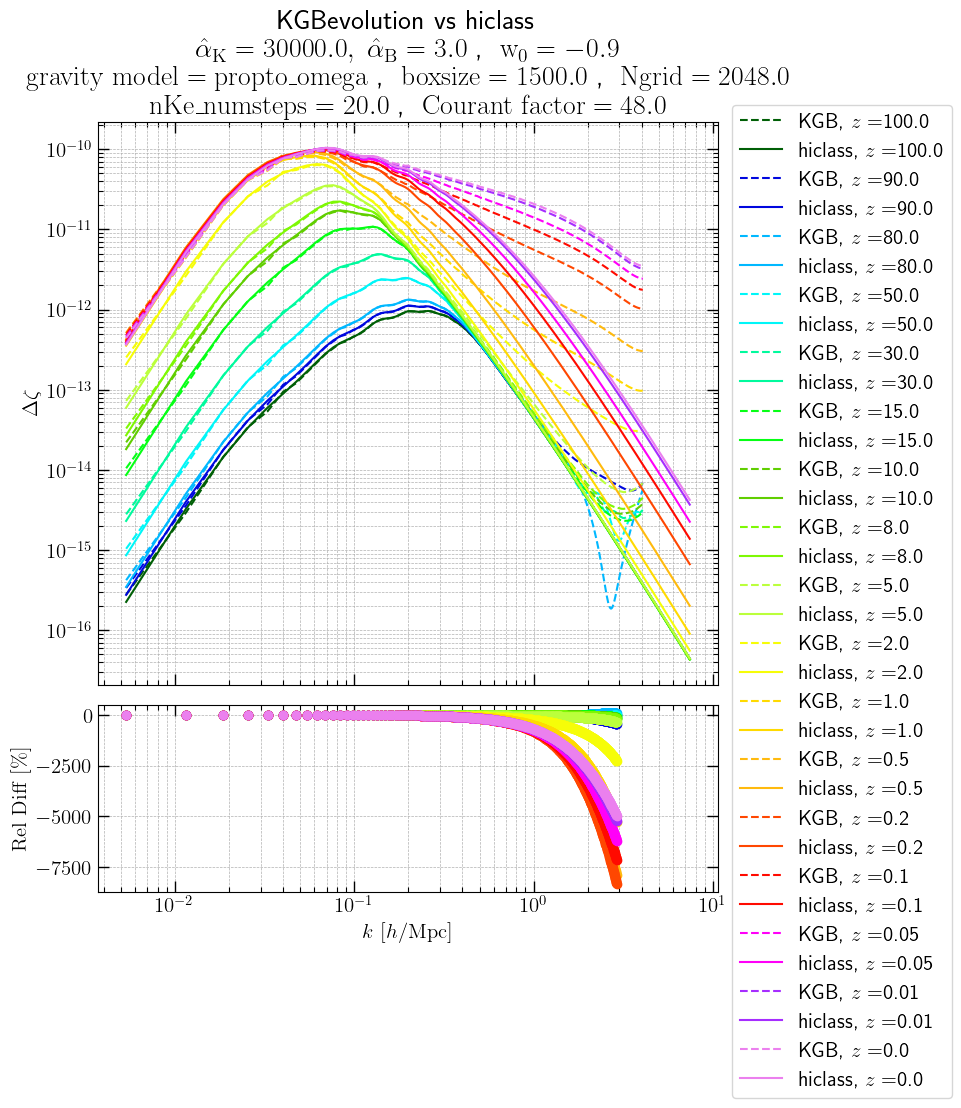

In [21]:
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.052, wspace=0.23)
plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}


for i in range(np.shape(redshifts)[0]):

    file_index = str(i).zfill(2)  
    
    #####################################################################################
    #                                              KGB
    
    data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_zeta.dat"
    )
    k = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 0]
    pk_kgb = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 1]

    
    ax[0].plot(k[:560], pk_kgb[:560], "--", c=colors[i], label="KGB, $z=$" + str(redshifts[i]))
    
    
#     data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#     f"./../{folder_name_kgb300}/pk_0{file_index}_zeta.dat"
#     )
#     k = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 0]
#     pk_kgb = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 1]

    
#     ax[0].plot(k[:460], pk_kgb[:460], ".", c=colors[i], alpha = 1, label="KGB, $z=$" + str(redshifts[i]))
    
    #####################################################################################
    #                                           kevolution
    
#     data_kev["kev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_zeta.dat"
#     )
#     k = data_kev["kev"]["zeta"]["z=" + str(redshifts[i])][:, 0]
#     pk_kev = data_kev["kev"]["zeta"]["z=" + str(redshifts[i])][:, 1]
    
#     ax[0].plot(k[:460], pk_kev[:460], ".", c=colors[i], label="Kevolution, $z=$" + str(redshifts[i]))
    
    #####################################################################################
    #                                              hiclass
    
    ax[0].plot(kk, pk_zeta_hi[i], c=colors[i], label="hiclass, $z=$" + str(redshifts[i]))
    
    
    ######################################################################################
    #                                            Rel Diff
    
#     ax[1].plot(
#         k[:460],
#         ((pk_kev[:460]- pk_kgb[:460])/ pk_kev[:460])*100,
#         "o",
#         c=colors[i],

#     )

    ini = 0
    fin = 400
    
    ax[1].plot(
        k[ini:fin],
        ((pk_zeta_hi[i][ini:fin]- pk_kgb[ini:fin])/ pk_zeta_hi[i][ini:fin])*100,
        "o",
        c=colors[i],
        label="KGB, $z=$" + str(redshifts[i]),
    )


for i in range(2):
    ax[i].set_xscale("log")


    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)

    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta \zeta$", fontsize=15)
ax[1].set_ylabel(r"$\mathrm{Rel~Diff}~ [\%]$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.05),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


ax[0].set_title(
    "KGBevolution vs hiclass"
    + "\n"
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    +"\n" + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$" + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("zeta_Rel_Diff_kev_kgb_3")

# matter power spectrum

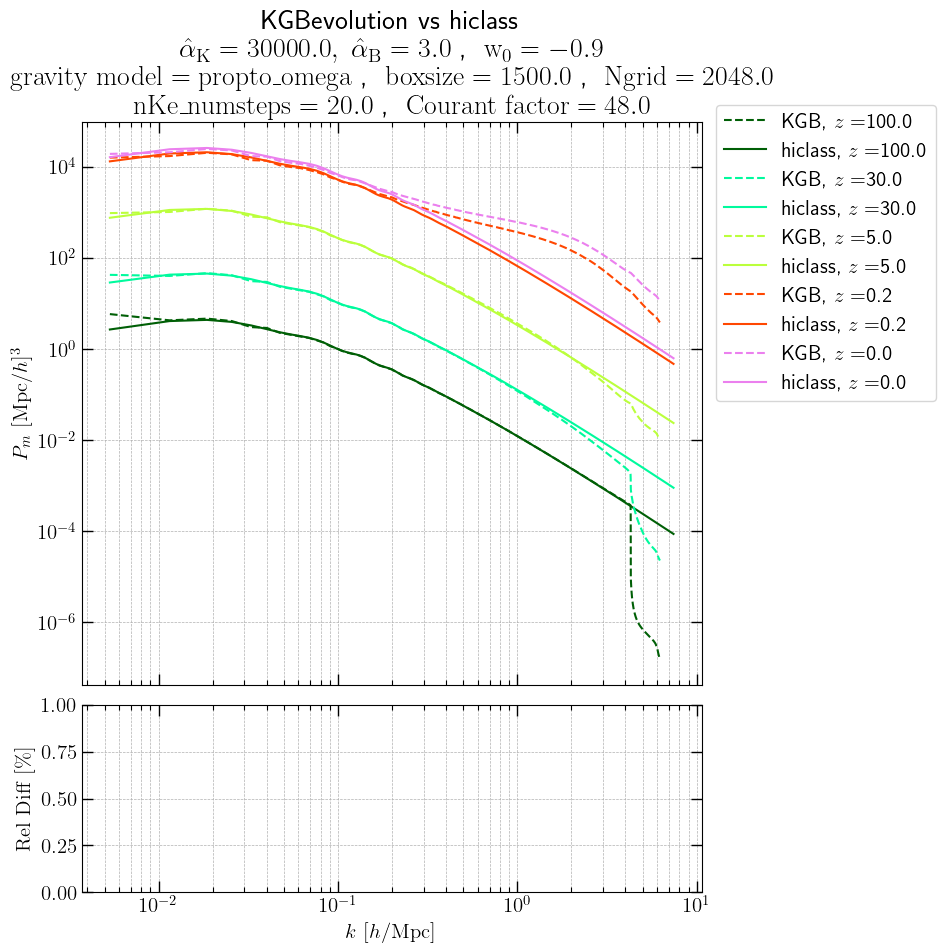

In [23]:
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.052, wspace=0.23)

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}
# Normlization*(vx_smg)**2


# # ax.plot(k_pi[:460],PP_pi[:460],'o', label = "KGB, $z=100$")
# for i in range(np.shape(redshifts)[0]):
#     data["kgb_ev"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
#         "./../impCluster/pk_00" + str(i) + "_pi_k.dat"
#     )
#     data["kgb_ev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         "./../impCluster/pk_00" + str(i) + "_zeta.dat"
#     )
#     k = data["kgb_ev"]["pi"]["z=" + str(redshifts[i])][:, 0]
#     pk = data["kgb_ev"]["pi"]["z=" + str(redshifts[i])][:, 1]

#     ax.plot(
#         kk,
#         pk_pi7_hi[i] * H0 * H0 / ((kk) ** 2),
#         c=colors[i],
#         label="hiclass, $z=$" + str(redshifts[i]),
#     )
#     ax.plot(k[:460], pk[:460], "o", c=colors[i], label="KGB, $z=$" + str(redshifts[i])
####################################################################################################
    #                                         KGB     
Pk_m =  [None] * len(z)

for i in range(np.shape(redshifts)[0])[::4]:
    
    file_index = str(i).zfill(2)  

    data_kgb["kgb"]["delta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_delta.dat"
    )

    k = data_kgb["kgb"]["delta"]["z=" + str(redshifts[i])][:, 0]
    pk_kgb = data_kgb["kgb"]["delta"]["z=" + str(redshifts[i])][:, 1]
    

    Pk_m = (pk_kgb*(2*(np.pi)**2)/((k)**3))

    ax[0].plot(
        k[:860], Pk_m[:860], "--", c=colors[i], label="KGB, $z=$" + str(redshifts[i]),
        markersize=8
    )
    
    ############################################################################
    #                                           Kevolution 
    
#     data_kev["kev"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_pi_k.dat"
#     )
#     data_kev["kev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_zeta.dat"
#     )
#     k = data_kev["kev"]["pi"]["z=" + str(redshifts[i])][:, 0]
#     pk_kev = data_kev["kev"]["pi"]["z=" + str(redshifts[i])][:, 1]
    
#     ax[0].plot(
#         k[:460], pk_kev[:460], ".", c=colors[i], label="kevolution, $z=$" + str(redshifts[i]),
#         markersize=8
#     )
    #############################################################################
    #                                         hiclass
    
    pk_hiclass = pk_pi7_hi[i] * H0 * H0 / ((kk) ** 2)
    
    ax[0].plot(
        kk,
        Pk_nl_hi[i],"-",
        c=colors[i],
        label="hiclass, $z=$" + str(redshifts[i]),
        markersize=6
    )
    ##############################################################################
    #                                         Rel Diff
    
#     ax[1].plot(
#         k[:460],
#         ((pk_kev[:460]- pk_kgb[:460])/pk_kev[:460])*100,
#         "o",
#         c=colors[i],

#     )

#     ini = 0
#     fin = 450

#     ax[1].plot(
#         k[ini:fin],
#         ((pk_hiclass[ini:fin]
#            - pk_kgb[ini:fin])/pk_hiclass[ini:fin])*100,
#         "o",
#         c=colors[i],
#         label="KGB, $z=$" + str(redshifts[i]),
#     )


for i in range(2):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$P_m~ [\mathrm{Mpc}/h]^3$", fontsize=15)
ax[1].set_ylabel(r"$\mathrm{Rel~Diff}~ [\%]$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)


ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.05),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


# Escape underscores in the gravity_model string
gravity_model = parser.get("top", "gravity_model")
gravity_model = gravity_model.replace("_", r"\_")

ax[0].set_title(" KGBevolution vs hiclass"
    + "\n"
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    + "\n"
    + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$"
    + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("pi_Rel_Diff_kev_kgb_3")

## Kevolution vs hiclass

In [279]:



fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.052, wspace=0.23)

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}
# Normlization*(vx_smg)**2


# # ax.plot(k_pi[:460],PP_pi[:460],'o', label = "KGB, $z=100$")
# for i in range(np.shape(redshifts)[0]):
#     data["kgb_ev"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
#         "./../impCluster/pk_00" + str(i) + "_pi_k.dat"
#     )
#     data["kgb_ev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         "./../impCluster/pk_00" + str(i) + "_zeta.dat"
#     )
#     k = data["kgb_ev"]["pi"]["z=" + str(redshifts[i])][:, 0]
#     pk = data["kgb_ev"]["pi"]["z=" + str(redshifts[i])][:, 1]

#     ax.plot(
#         kk,
#         pk_pi7_hi[i] * H0 * H0 / ((kk) ** 2),
#         c=colors[i],
#         label="hiclass, $z=$" + str(redshifts[i]),
#     )
#     ax.plot(k[:460], pk[:460], "o", c=colors[i], label="KGB, $z=$" + str(redshifts[i]))

for i in range(np.shape(redshifts)[0]):
    
    file_index = str(i).zfill(2)  
    ############################################################################
    #                                             KGB 
    
    data_kgb["kgb"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_pi_k.dat"
    )
    data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_zeta.dat"
    )
    k = data_kgb["kgb"]["pi"]["z=" + str(redshifts[i])][:, 0]
    pk_kgb = data_kgb["kgb"]["pi"]["z=" + str(redshifts[i])][:, 1]

#     ax[0].plot(
#         k[:460], pk_kgb[:460], "o", c=colors[i],alpha = 0.2, label="KGB, $z=$" + str(redshifts[i]),
#         markersize=8
#     )
    
    ############################################################################
    #                                           Kevolution 
    
    data_kev["kev"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kev}/pk_0{file_index}_pi_k.dat"
    )
    data_kev["kev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kev}/pk_0{file_index}_zeta.dat"
    )
    k = data_kev["kev"]["pi"]["z=" + str(redshifts[i])][:, 0]
    pk_kev = data_kev["kev"]["pi"]["z=" + str(redshifts[i])][:, 1]
    
    ax[0].plot(
        k[:460], pk_kev[:460], ".", c=colors[i], label="kevolution, $z=$" + str(redshifts[i]),
        markersize=8
    )
    #############################################################################
    #                                         hiclass
    
    pk_hiclass = pk_pi7_hi[i] * H0 * H0 / ((kk) ** 2)
    
    ax[0].plot(
        kk,
        pk_hiclass,"-",
        c=colors[i],
        label="hiclass, $z=$" + str(redshifts[i]),
        markersize=6
    )
    ##############################################################################
    #                                         Rel Diff
    
#     ax[1].plot(
#         k[:460],
#         ((pk_kev[:460]- pk_kgb[:460])/pk_kev[:460])*100,
#         "o",
#         c=colors[i],

#     )

    ini = 0
    fin = 400

    ax[1].plot(
        k[ini:fin],
        ((pk_hiclass[ini:fin]
           - pk_kev[ini:fin])/pk_hiclass[ini:fin])*100,
        "o",
        c=colors[i],
        label="KGB, $z=$" + str(redshifts[i]),
    )


for i in range(2):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta \pi$", fontsize=15)
ax[1].set_ylabel(r"$\mathrm{Rel~Diff}~ [\%]$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)


ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.05),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


# Escape underscores in the gravity_model string
gravity_model = parser.get("top", "gravity_model")
gravity_model = gravity_model.replace("_", r"\_")

ax[0].set_title(" Kevolution vs hiclass"
    + "\n"
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    + "\n"
    + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$"
    + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("pi_Rel_Diff_kev_kgb_3")

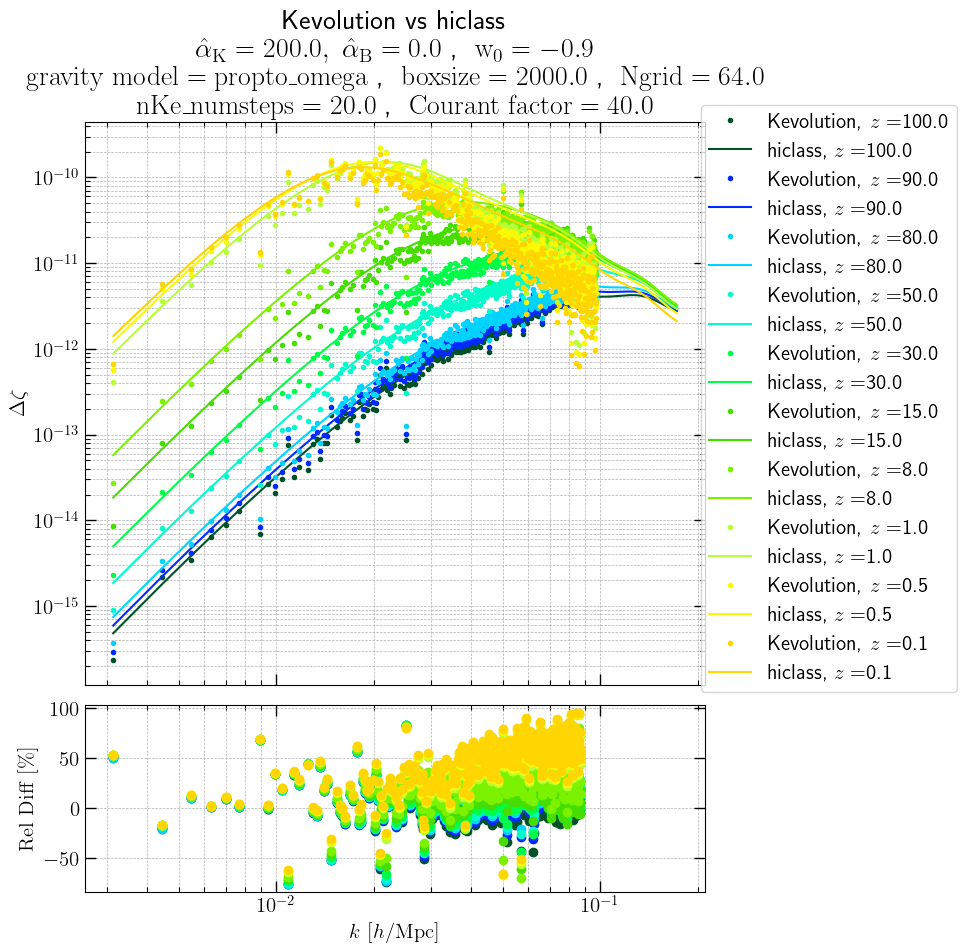

In [280]:
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.052, wspace=0.23)
plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}


for i in range(np.shape(redshifts)[0]):

    file_index = str(i).zfill(2)  
    
    #####################################################################################
    #                                              KGB
    
    data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_zeta.dat"
    )
    k = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 0]
    pk_kgb = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 1]

    
#     ax[0].plot(k[:460], pk_kgb[:460], "o", c=colors[i], alpha = 0.6, label="KGB, $z=$" + str(redshifts[i]))
    
    #####################################################################################
    #                                           kevolution
    
    data_kev["kev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kev}/pk_0{file_index}_zeta.dat"
    )
    k = data_kev["kev"]["zeta"]["z=" + str(redshifts[i])][:, 0]
    pk_kev = data_kev["kev"]["zeta"]["z=" + str(redshifts[i])][:, 1]
    
    ax[0].plot(k[:460], pk_kev[:460], ".", c=colors[i], label="Kevolution, $z=$" + str(redshifts[i]))
    
    #####################################################################################
    #                                              hiclass
    
    ax[0].plot(kk, pk_zeta_hi[i], c=colors[i], label="hiclass, $z=$" + str(redshifts[i]))
    
    
    ######################################################################################
    #                                            Rel Diff
    
#     ax[1].plot(
#         k[:460],
#         ((pk_kev[:460]- pk_kgb[:460])/ pk_kev[:460])*100,
#         "o",
#         c=colors[i],

#     )

    ini = 0
    fin = 400
    
    ax[1].plot(
        k[ini:fin],
        ((pk_zeta_hi[i][ini:fin]- pk_kgb[ini:fin])/ pk_zeta_hi[i][ini:fin])*100,
        "o",
        c=colors[i],
        label="KGB, $z=$" + str(redshifts[i]),
    )


for i in range(2):
    ax[i].set_xscale("log")


    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)

    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta \zeta$", fontsize=15)
ax[1].set_ylabel(r"$\mathrm{Rel~Diff}~ [\%]$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.05),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


ax[0].set_title(
    "Kevolution vs hiclass"
    + "\n"
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    +"\n" + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$" + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("zeta_Rel_Diff_kev_kgb_3")

## KGB vs hiclass using $T_{kessence}$

In [316]:



fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.052, wspace=0.23)

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}
# Normlization*(vx_smg)**2


# # ax.plot(k_pi[:460],PP_pi[:460],'o', label = "KGB, $z=100$")
# for i in range(np.shape(redshifts)[0]):
#     data["kgb_ev"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
#         "./../impCluster/pk_00" + str(i) + "_pi_k.dat"
#     )
#     data["kgb_ev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         "./../impCluster/pk_00" + str(i) + "_zeta.dat"
#     )
#     k = data["kgb_ev"]["pi"]["z=" + str(redshifts[i])][:, 0]
#     pk = data["kgb_ev"]["pi"]["z=" + str(redshifts[i])][:, 1]

#     ax.plot(
#         kk,
#         pk_pi7_hi[i] * H0 * H0 / ((kk) ** 2),
#         c=colors[i],
#         label="hiclass, $z=$" + str(redshifts[i]),
#     )
#     ax.plot(k[:460], pk[:460], "o", c=colors[i], label="KGB, $z=$" + str(redshifts[i]))

for i in range(np.shape(redshifts)[0]):
    
    file_index = str(i).zfill(2)  
    ############################################################################
    #                                             KGB 
    
    data_kgb["kgb"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_pi_k.dat"
    )
    data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_zeta.dat"
    )
    k = data_kgb["kgb"]["pi"]["z=" + str(redshifts[i])][:, 0]
    pk_kgb = data_kgb["kgb"]["pi"]["z=" + str(redshifts[i])][:, 1]

    ax[0].plot(
        k[:460], pk_kgb[:460], ".", c=colors[i], label="KGB, $z=$" + str(redshifts[i]),
        markersize=8
    )
    
    ############################################################################
    #                                           Kevolution 
    
#     data_kev["kev"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_pi_k.dat"
#     )
#     data_kev["kev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_zeta.dat"
#     )
#     k = data_kev["kev"]["pi"]["z=" + str(redshifts[i])][:, 0]
#     pk_kev = data_kev["kev"]["pi"]["z=" + str(redshifts[i])][:, 1]
    
#     ax[0].plot(
#         k[:460], pk_kev[:460], ".", c=colors[i], label="kevolution, $z=$" + str(redshifts[i]),
#         markersize=8
#     )
    #############################################################################
    #                                         hiclass
    
    pk_hiclass = pk_pi7_hi[i] * H0 * H0 / ((kk) ** 2)
    
    ax[0].plot(
        kk,
        pk_hiclass,"-",
        c=colors[i],
        label="hiclass, $z=$" + str(redshifts[i]),
        markersize=6
    )
    ##############################################################################
    #                                         Rel Diff
    
#     ax[1].plot(
#         k[:460],
#         ((pk_kev[:460]- pk_kgb[:460])/pk_kev[:460])*100,
#         "o",
#         c=colors[i],

#     )

    ini = 0
    fin = 450

    ax[1].plot(
        k[ini:fin],
        ((pk_hiclass[ini:fin]
           - pk_kgb[ini:fin])/pk_hiclass[ini:fin])*100,
        "o",
        c=colors[i],
        label="KGB, $z=$" + str(redshifts[i]),
    )


for i in range(2):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta \pi$", fontsize=15)
ax[1].set_ylabel(r"$\mathrm{Rel~Diff}~ [\%]$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)


ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.05),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


# Escape underscores in the gravity_model string
gravity_model = parser.get("top", "gravity_model")
gravity_model = gravity_model.replace("_", r"\_")

ax[0].set_title(" KGB (T_kess) vs hiclass"
    + "\n"
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    + "\n"
    + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$"
    + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("pi_Rel_Diff_kev_kgb_3")

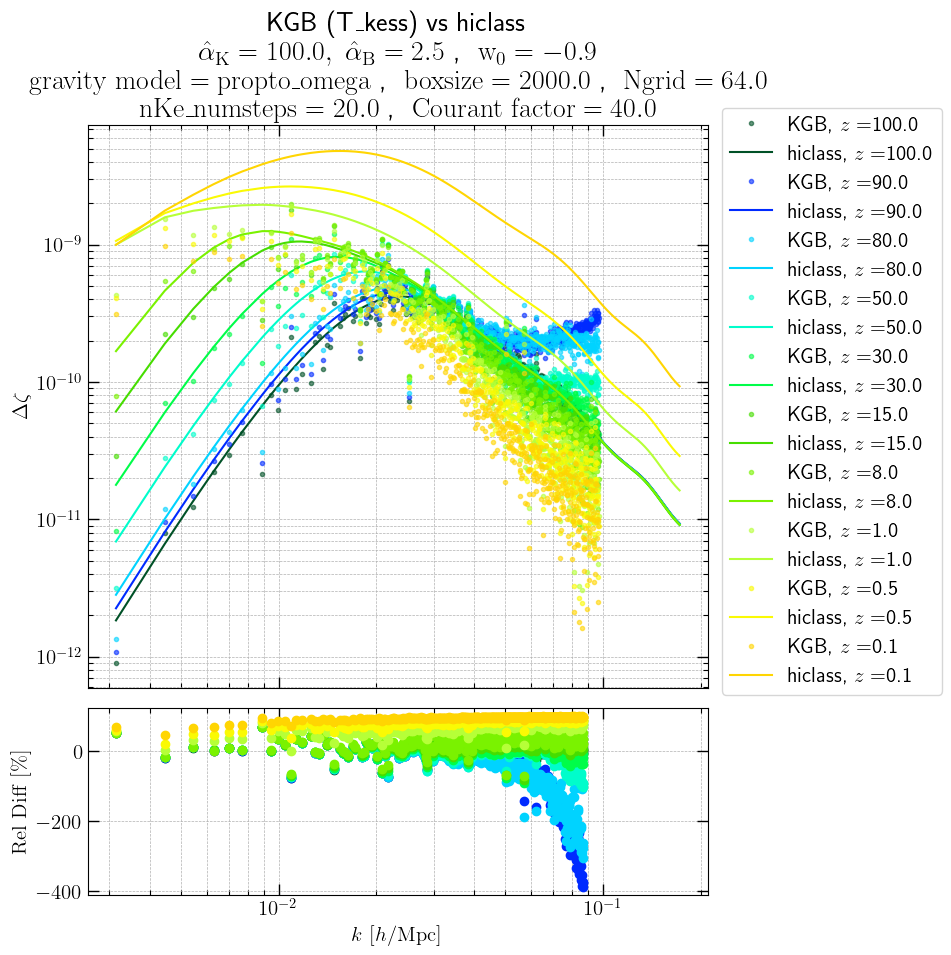

In [317]:
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.052, wspace=0.23)
plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}


for i in range(np.shape(redshifts)[0]):

    file_index = str(i).zfill(2)  
    
    #####################################################################################
    #                                              KGB
    
    data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_zeta.dat"
    )
    k = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 0]
    pk_kgb = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 1]

    
    ax[0].plot(k[:460], pk_kgb[:460], ".", c=colors[i], label="KGB, $z=$" + str(redshifts[i]))
    
    #####################################################################################
    #                                           kevolution
    
#     data_kev["kev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_zeta.dat"
#     )
#     k = data_kev["kev"]["zeta"]["z=" + str(redshifts[i])][:, 0]
#     pk_kev = data_kev["kev"]["zeta"]["z=" + str(redshifts[i])][:, 1]
    
#     ax[0].plot(k[:460], pk_kev[:460], ".", c=colors[i], label="Kevolution, $z=$" + str(redshifts[i]))
    
    #####################################################################################
    #                                              hiclass
    
    ax[0].plot(kk, pk_zeta_hi[i], c=colors[i], label="hiclass, $z=$" + str(redshifts[i]))
    
    
    ######################################################################################
    #                                            Rel Diff
    
#     ax[1].plot(
#         k[:460],
#         ((pk_kev[:460]- pk_kgb[:460])/ pk_kev[:460])*100,
#         "o",
#         c=colors[i],

#     )

    ini = 0
    fin = 400
    
    ax[1].plot(
        k[ini:fin],
        ((pk_zeta_hi[i][ini:fin]- pk_kgb[ini:fin])/ pk_zeta_hi[i][ini:fin])*100,
        "o",
        c=colors[i],
        label="KGB, $z=$" + str(redshifts[i]),
    )


for i in range(2):
    ax[i].set_xscale("log")


    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)

    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta \zeta$", fontsize=15)
ax[1].set_ylabel(r"$\mathrm{Rel~Diff}~ [\%]$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.05),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


ax[0].set_title(
    "KGB (T_kess) vs hiclass"
    + "\n"
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    +"\n" + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$" + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("zeta_Rel_Diff_kev_kgb_3")

## KGB vs hiclass using $T_{KGB}$

In [336]:
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.052, wspace=0.23)

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}
# Normlization*(vx_smg)**2


# # ax.plot(k_pi[:460],PP_pi[:460],'o', label = "KGB, $z=100$")
# for i in range(np.shape(redshifts)[0]):
#     data["kgb_ev"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
#         "./../impCluster/pk_00" + str(i) + "_pi_k.dat"
#     )
#     data["kgb_ev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         "./../impCluster/pk_00" + str(i) + "_zeta.dat"
#     )
#     k = data["kgb_ev"]["pi"]["z=" + str(redshifts[i])][:, 0]
#     pk = data["kgb_ev"]["pi"]["z=" + str(redshifts[i])][:, 1]

#     ax.plot(
#         kk,
#         pk_pi7_hi[i] * H0 * H0 / ((kk) ** 2),
#         c=colors[i],
#         label="hiclass, $z=$" + str(redshifts[i]),
#     )
#     ax.plot(k[:460], pk[:460], "o", c=colors[i], label="KGB, $z=$" + str(redshifts[i]))

for i in range(np.shape(redshifts)[0]):
    
    file_index = str(i).zfill(2)  
    ############################################################################
    #                                             KGB 
    
    data_kgb["kgb"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_pi_k.dat"
    )
    data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_zeta.dat"
    )
    k = data_kgb["kgb"]["pi"]["z=" + str(redshifts[i])][:, 0]
    pk_kgb = data_kgb["kgb"]["pi"]["z=" + str(redshifts[i])][:, 1]

    ax[0].plot(
        k[:460], pk_kgb[:460], ".", c=colors[i], label="KGB, $z=$" + str(redshifts[i]),
        markersize=8
    )
    
    ############################################################################
    #                                           Kevolution 
    
#     data_kev["kev"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_pi_k.dat"
#     )
#     data_kev["kev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_zeta.dat"
#     )
#     k = data_kev["kev"]["pi"]["z=" + str(redshifts[i])][:, 0]
#     pk_kev = data_kev["kev"]["pi"]["z=" + str(redshifts[i])][:, 1]
    
#     ax[0].plot(
#         k[:460], pk_kev[:460], ".", c=colors[i], label="kevolution, $z=$" + str(redshifts[i]),
#         markersize=8
#     )
    #############################################################################
    #                                         hiclass
    
    pk_hiclass = pk_pi7_hi[i] * H0 * H0 / ((kk) ** 2)
    
    ax[0].plot(
        kk,
        pk_hiclass,"-",
        c=colors[i],
        label="hiclass, $z=$" + str(redshifts[i]),
        markersize=6
    )
    ##############################################################################
    #                                         Rel Diff
    
#     ax[1].plot(
#         k[:460],
#         ((pk_kev[:460]- pk_kgb[:460])/pk_kev[:460])*100,
#         "o",
#         c=colors[i],

#     )

    ini = 0
    fin = 450

    ax[1].plot(
        k[ini:fin],
        ((pk_hiclass[ini:fin]
           - pk_kgb[ini:fin])/pk_hiclass[ini:fin])*100,
        "o",
        c=colors[i],
        label="KGB, $z=$" + str(redshifts[i]),
    )


for i in range(2):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta \pi$", fontsize=15)
ax[1].set_ylabel(r"$\mathrm{Rel~Diff}~ [\%]$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)


ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.05),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


# Escape underscores in the gravity_model string
gravity_model = parser.get("top", "gravity_model")
gravity_model = gravity_model.replace("_", r"\_")

ax[0].set_title(" KGB (T_KGB) vs hiclass"
    + "\n"
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    + "\n"
    + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$"
    + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("pi_Rel_Diff_kev_kgb_3")

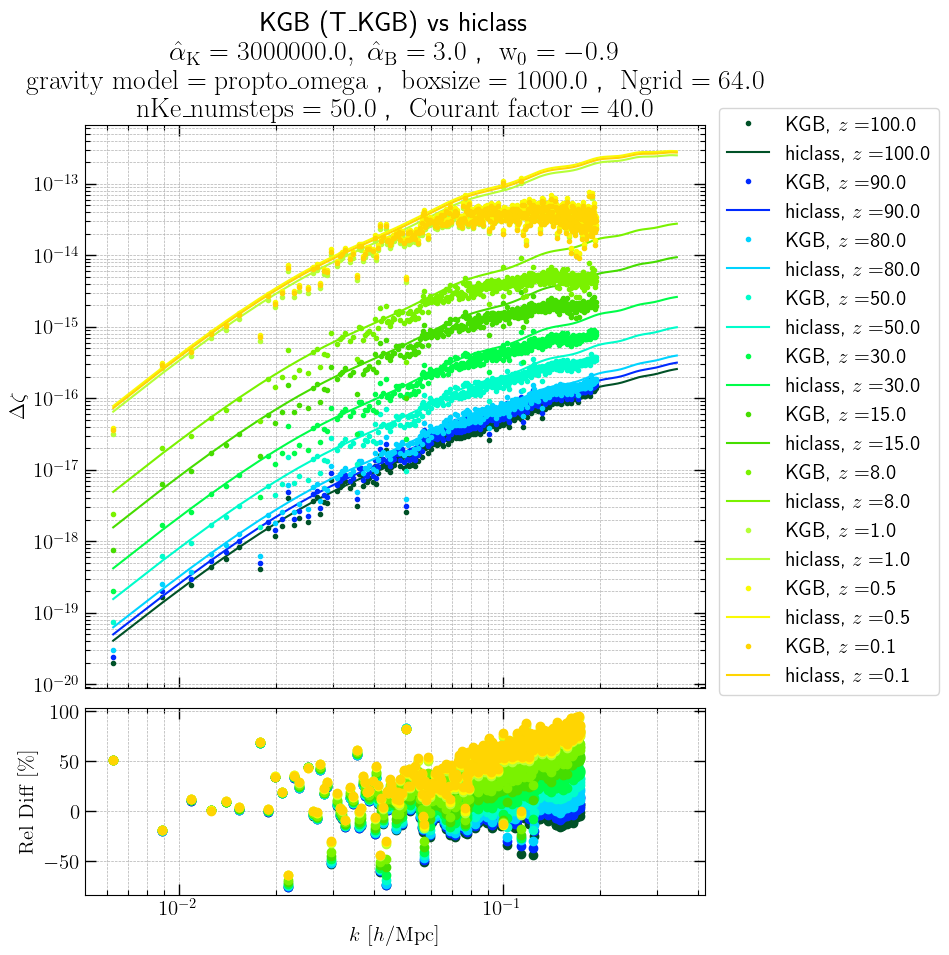

In [337]:
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.052, wspace=0.23)
plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}


for i in range(np.shape(redshifts)[0]):

    file_index = str(i).zfill(2)  
    
    #####################################################################################
    #                                              KGB
    
    data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_zeta.dat"
    )
    k = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 0]
    pk_kgb = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 1]

    
    ax[0].plot(k[:460], pk_kgb[:460], ".", c=colors[i], label="KGB, $z=$" + str(redshifts[i]))
    
    #####################################################################################
    #                                           kevolution
    
#     data_kev["kev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_zeta.dat"
#     )
#     k = data_kev["kev"]["zeta"]["z=" + str(redshifts[i])][:, 0]
#     pk_kev = data_kev["kev"]["zeta"]["z=" + str(redshifts[i])][:, 1]
    
#     ax[0].plot(k[:460], pk_kev[:460], ".", c=colors[i], label="Kevolution, $z=$" + str(redshifts[i]))
    
    #####################################################################################
    #                                              hiclass
    
    ax[0].plot(kk, pk_zeta_hi[i], c=colors[i], label="hiclass, $z=$" + str(redshifts[i]))
    
    
    ######################################################################################
    #                                            Rel Diff
    
#     ax[1].plot(
#         k[:460],
#         ((pk_kev[:460]- pk_kgb[:460])/ pk_kev[:460])*100,
#         "o",
#         c=colors[i],

#     )

    ini = 0
    fin = 400
    
    ax[1].plot(
        k[ini:fin],
        ((pk_zeta_hi[i][ini:fin]- pk_kgb[ini:fin])/ pk_zeta_hi[i][ini:fin])*100,
        "o",
        c=colors[i],
        label="KGB, $z=$" + str(redshifts[i]),
    )


for i in range(2):
    ax[i].set_xscale("log")


    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)

    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta \zeta$", fontsize=15)
ax[1].set_ylabel(r"$\mathrm{Rel~Diff}~ [\%]$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.05),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


ax[0].set_title(
    "KGB (T_KGB) vs hiclass"
    + "\n"
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    +"\n" + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$" + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("zeta_Rel_Diff_kev_kgb_3")

## smaller box (1000)

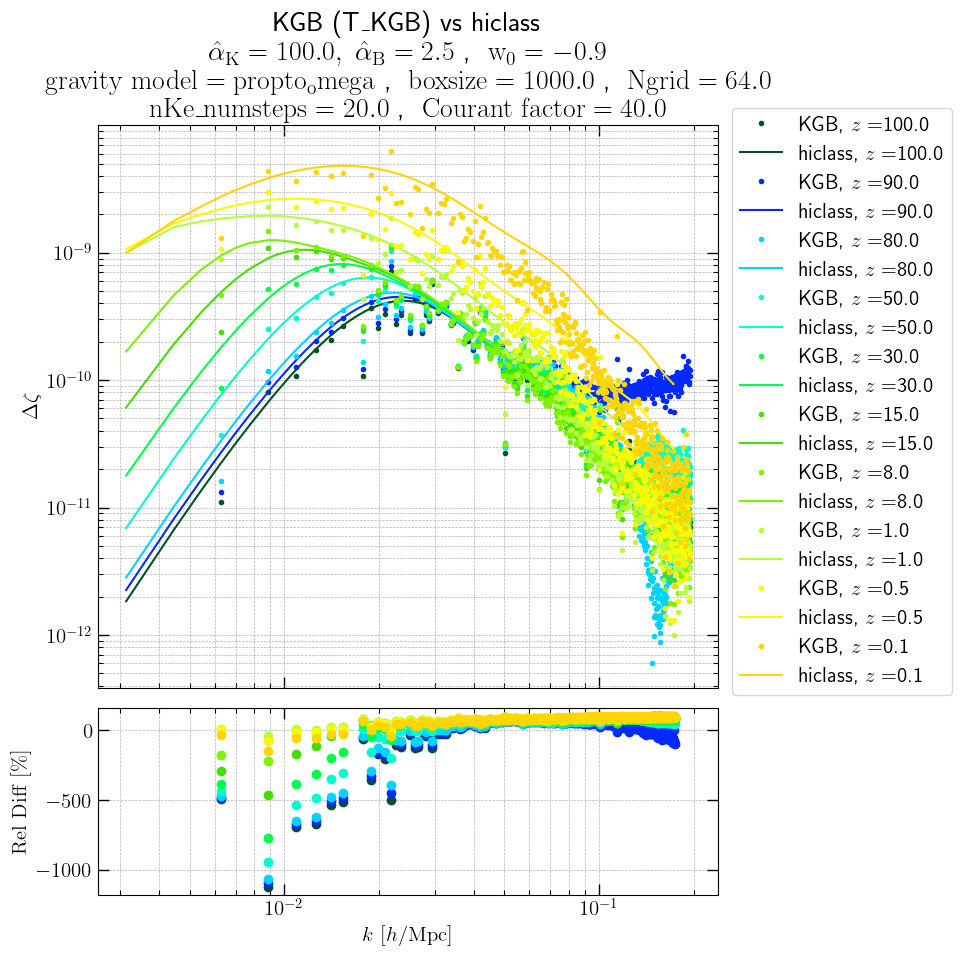

In [324]:
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.052, wspace=0.23)
plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}


for i in range(np.shape(redshifts)[0]):

    file_index = str(i).zfill(2)  
    
    #####################################################################################
    #                                              KGB
    
    data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_zeta.dat"
    )
    k = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 0]
    pk_kgb = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 1]

    
    ax[0].plot(k[:460], pk_kgb[:460], ".", c=colors[i], label="KGB, $z=$" + str(redshifts[i]))
    
    #####################################################################################
    #                                           kevolution
    
#     data_kev["kev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_zeta.dat"
#     )
#     k = data_kev["kev"]["zeta"]["z=" + str(redshifts[i])][:, 0]
#     pk_kev = data_kev["kev"]["zeta"]["z=" + str(redshifts[i])][:, 1]
    
#     ax[0].plot(k[:460], pk_kev[:460], ".", c=colors[i], label="Kevolution, $z=$" + str(redshifts[i]))
    
    #####################################################################################
    #                                              hiclass
    
    ax[0].plot(kk, pk_zeta_hi[i], c=colors[i], label="hiclass, $z=$" + str(redshifts[i]))
    
    
    ######################################################################################
    #                                            Rel Diff
    
#     ax[1].plot(
#         k[:460],
#         ((pk_kev[:460]- pk_kgb[:460])/ pk_kev[:460])*100,
#         "o",
#         c=colors[i],

#     )

    ini = 0
    fin = 400
    
    ax[1].plot(
        k[ini:fin],
        ((pk_zeta_hi[i][ini:fin]- pk_kgb[ini:fin])/ pk_zeta_hi[i][ini:fin])*100,
        "o",
        c=colors[i],
        label="KGB, $z=$" + str(redshifts[i]),
    )


for i in range(2):
    ax[i].set_xscale("log")


    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)

    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta \zeta$", fontsize=15)
ax[1].set_ylabel(r"$\mathrm{Rel~Diff}~ [\%]$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.05),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


ax[0].set_title(
    "KGB (T_KGB) vs hiclass"
    + "\n"
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    +"\n" + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$" + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("zeta_Rel_Diff_kev_kgb_3")

## small $\alpha_K =1 $

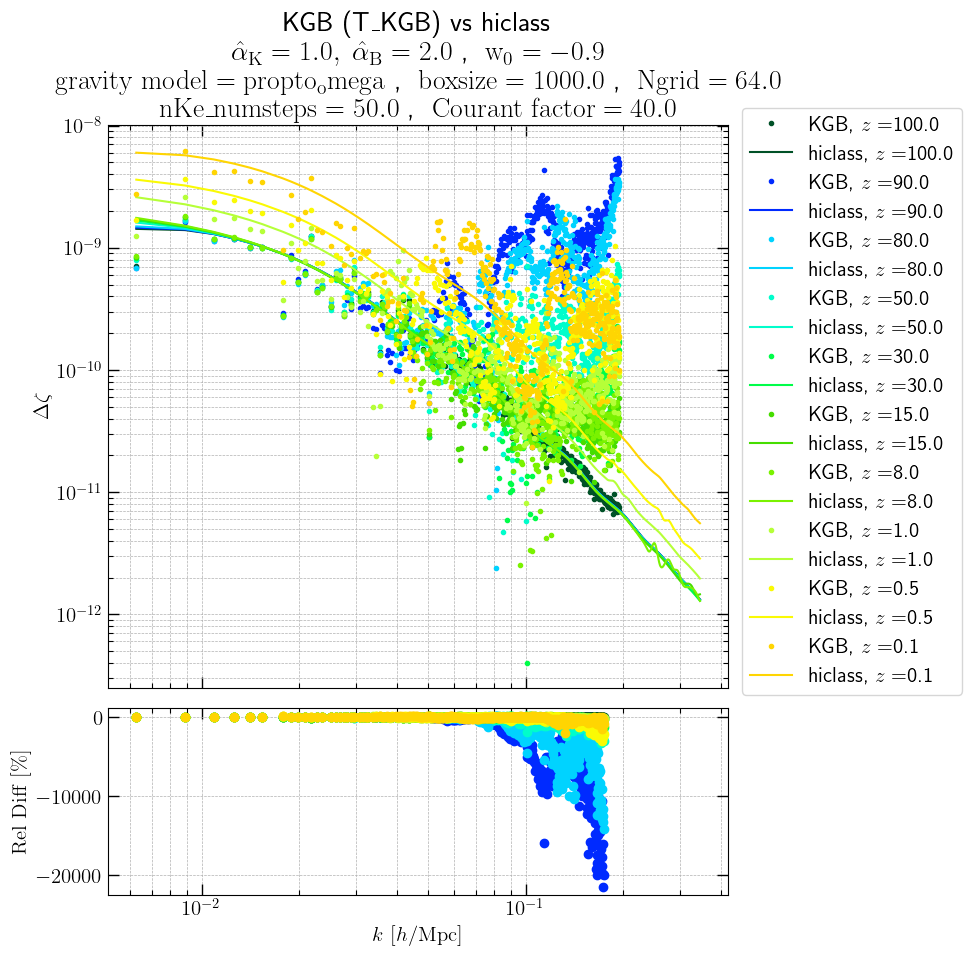

In [328]:
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.052, wspace=0.23)
plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}


for i in range(np.shape(redshifts)[0]):

    file_index = str(i).zfill(2)  
    
    #####################################################################################
    #                                              KGB
    
    data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_zeta.dat"
    )
    k = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 0]
    pk_kgb = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 1]

    
    ax[0].plot(k[:460], pk_kgb[:460], ".", c=colors[i], label="KGB, $z=$" + str(redshifts[i]))
    
    #####################################################################################
    #                                           kevolution
    
#     data_kev["kev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_zeta.dat"
#     )
#     k = data_kev["kev"]["zeta"]["z=" + str(redshifts[i])][:, 0]
#     pk_kev = data_kev["kev"]["zeta"]["z=" + str(redshifts[i])][:, 1]
    
#     ax[0].plot(k[:460], pk_kev[:460], ".", c=colors[i], label="Kevolution, $z=$" + str(redshifts[i]))
    
    #####################################################################################
    #                                              hiclass
    
    ax[0].plot(kk, pk_zeta_hi[i], c=colors[i], label="hiclass, $z=$" + str(redshifts[i]))
    
    
    ######################################################################################
    #                                            Rel Diff
    
#     ax[1].plot(
#         k[:460],
#         ((pk_kev[:460]- pk_kgb[:460])/ pk_kev[:460])*100,
#         "o",
#         c=colors[i],

#     )

    ini = 0
    fin = 400
    
    ax[1].plot(
        k[ini:fin],
        ((pk_zeta_hi[i][ini:fin]- pk_kgb[ini:fin])/ pk_zeta_hi[i][ini:fin])*100,
        "o",
        c=colors[i],
        label="KGB, $z=$" + str(redshifts[i]),
    )


for i in range(2):
    ax[i].set_xscale("log")


    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)

    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta \zeta$", fontsize=15)
ax[1].set_ylabel(r"$\mathrm{Rel~Diff}~ [\%]$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.05),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


ax[0].set_title(
    "KGB (T_KGB) vs hiclass"
    + "\n"
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    +"\n" + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$" + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("zeta_Rel_Diff_kev_kgb_3")

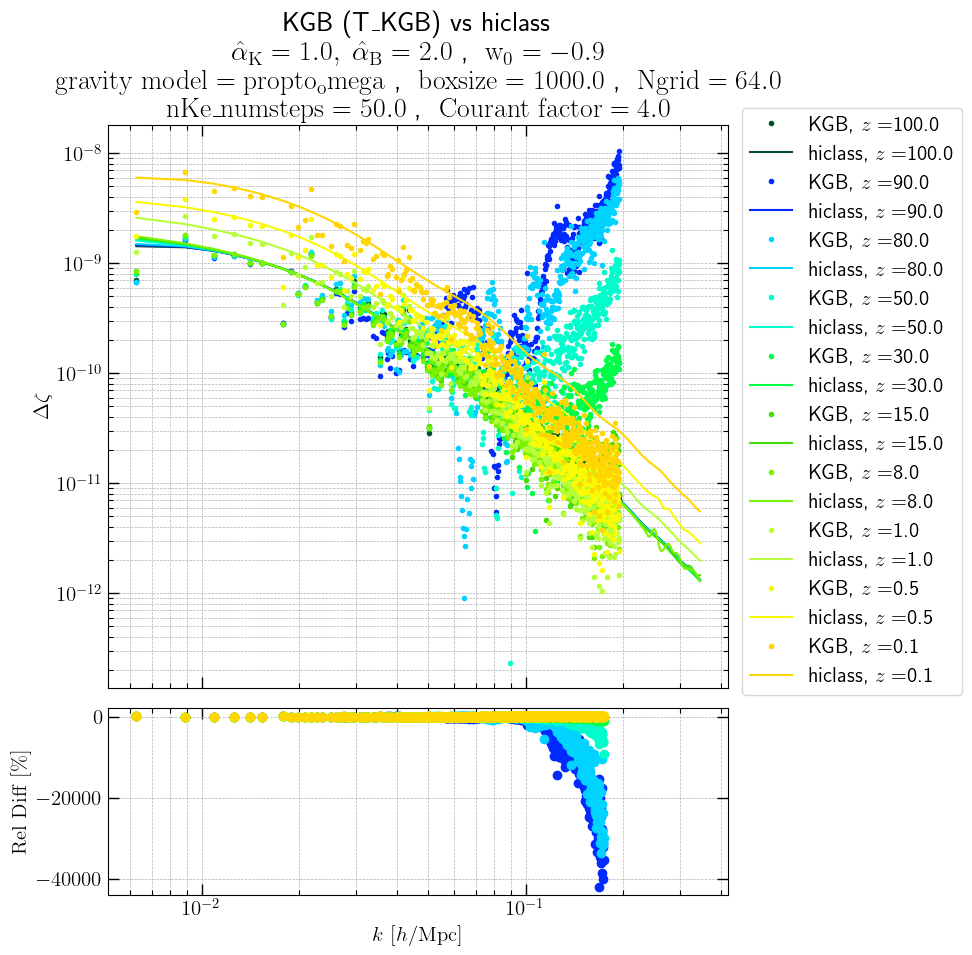

In [332]:
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.052, wspace=0.23)
plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}


for i in range(np.shape(redshifts)[0]):

    file_index = str(i).zfill(2)  
    
    #####################################################################################
    #                                              KGB
    
    data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_zeta.dat"
    )
    k = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 0]
    pk_kgb = data_kgb["kgb"]["zeta"]["z=" + str(redshifts[i])][:, 1]

    
    ax[0].plot(k[:460], pk_kgb[:460], ".", c=colors[i], label="KGB, $z=$" + str(redshifts[i]))
    
    #####################################################################################
    #                                           kevolution
    
#     data_kev["kev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
#         f"./../{folder_name_kev}/pk_0{file_index}_zeta.dat"
#     )
#     k = data_kev["kev"]["zeta"]["z=" + str(redshifts[i])][:, 0]
#     pk_kev = data_kev["kev"]["zeta"]["z=" + str(redshifts[i])][:, 1]
    
#     ax[0].plot(k[:460], pk_kev[:460], ".", c=colors[i], label="Kevolution, $z=$" + str(redshifts[i]))
    
    #####################################################################################
    #                                              hiclass
    
    ax[0].plot(kk, pk_zeta_hi[i], c=colors[i], label="hiclass, $z=$" + str(redshifts[i]))
    
    
    ######################################################################################
    #                                            Rel Diff
    
#     ax[1].plot(
#         k[:460],
#         ((pk_kev[:460]- pk_kgb[:460])/ pk_kev[:460])*100,
#         "o",
#         c=colors[i],

#     )

    ini = 0
    fin = 400
    
    ax[1].plot(
        k[ini:fin],
        ((pk_zeta_hi[i][ini:fin]- pk_kgb[ini:fin])/ pk_zeta_hi[i][ini:fin])*100,
        "o",
        c=colors[i],
        label="KGB, $z=$" + str(redshifts[i]),
    )


for i in range(2):
    ax[i].set_xscale("log")


    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)

    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta \zeta$", fontsize=15)
ax[1].set_ylabel(r"$\mathrm{Rel~Diff}~ [\%]$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.05),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


ax[0].set_title(
    "KGB (T_KGB) vs hiclass"
    + "\n"
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    +"\n" + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$" + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("zeta_Rel_Diff_kev_kgb_3")

## Cluster simulations

In [107]:
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.012, wspace=0.23)

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}


for i in range(np.shape(redshifts)[0]):
    # Format `i` to ensure filenames are correct
    file_index = str(i).zfill(2)  # Pads with one leading zero if `i` is a single digit

    # Load data using the formatted `file_index`
    data["kgb_ev"]["pi"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_pi_k.dat"
    )
    data["kgb_ev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_zeta.dat"
    )
    k = data["kgb_ev"]["pi"]["z=" + str(redshifts[i])][:, 0]
    pk = data["kgb_ev"]["pi"]["z=" + str(redshifts[i])][:, 1]
    
    pk_pi_hiclass = pk_pi7_hi[i] * H0 * H0 / ((kk) ** 2)

    ax[0].plot(
        kk[8:70],
        pk_pi_hiclass[8:70],"-",
        c=colors[i],
        label="hiclass, $z=$" + str(redshifts[i]),
        markersize=6
    )
    ax[0].plot(
        k[8:70], pk[8:70], "o", c=colors[i], label="KGB, $z=$" + str(redshifts[i]),
        markersize=8
    )
    ax[1].plot(
        k[8:70],
        ((pk_pi_hiclass[8:70] - pk[8:70])/ pk_pi_hiclass[8:70])*100,
        "o",
        c=colors[i],
        label="KGB, $z=$" + str(redshifts[i]),
    )


for i in range(2):
    ax[i].set_xscale("log")
    ax[i].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)

    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta \pi$", fontsize=15)
ax[1].set_ylabel(r"$\mathrm{Rel Diff}~ [\%]$", fontsize=15)


ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.05),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


# Escape underscores in the gravity_model string
gravity_model = parser.get("top", "gravity_model")
gravity_model = gravity_model.replace("_", r"\_")

ax[0].set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    + "\n"
    + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$"
    + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

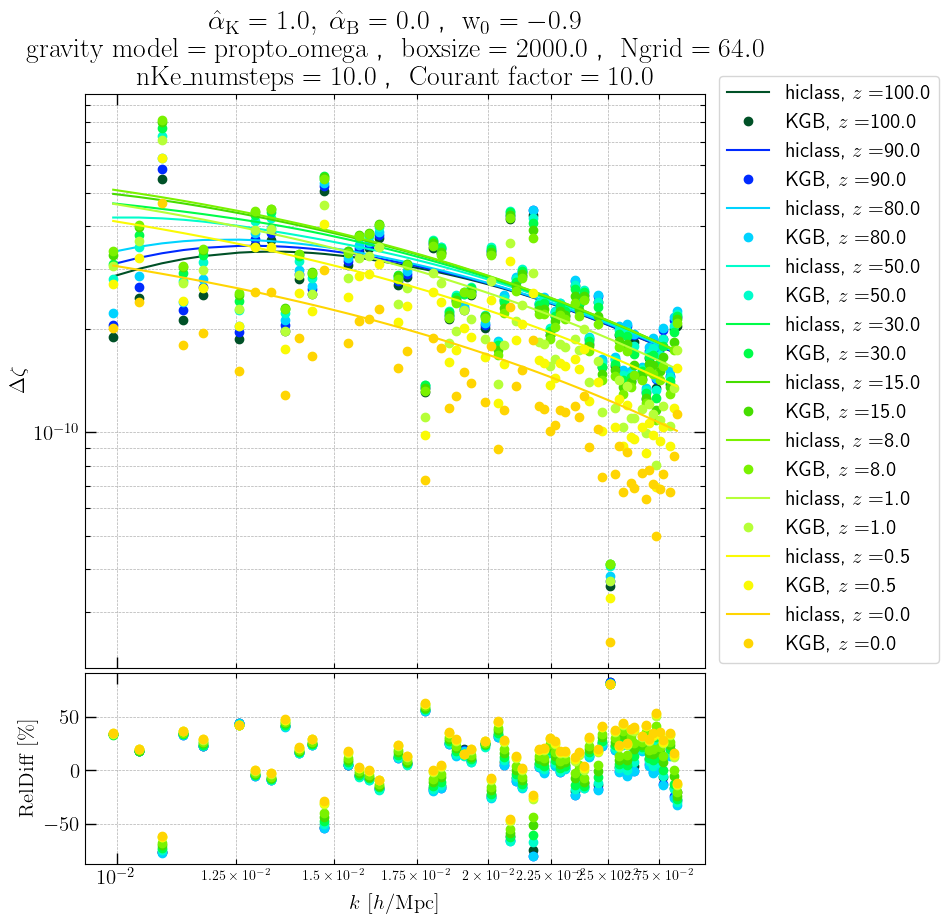

In [108]:
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.012, wspace=0.23)
plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}
# Normlization*(vx_smg)**2


# ax.plot(k_pi[:460],PP_pi[:460],'o', label = "KGB, $z=100$")
for i in range(np.shape(redshifts)[0]):
    # Format `i` to ensure filenames are correct
    file_index = str(i).zfill(2)  # Pads with one leading zero if `i` is a single digit
    
    data["kgb_ev"]["zeta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_zeta.dat"
    )
    k = data["kgb_ev"]["zeta"]["z=" + str(redshifts[i])][:, 0]
    pk = data["kgb_ev"]["zeta"]["z=" + str(redshifts[i])][:, 1]

    ax[0].plot(kk[8:70], pk_zeta_hi[i][8:70], c=colors[i], label="hiclass, $z=$" + str(redshifts[i]))
    ax[0].plot(k[8:70], pk[8:70], "o", c=colors[i], label="KGB, $z=$" + str(redshifts[i]))
    ax[1].plot(
        k[8:70],
        ((pk_zeta_hi[i][8:70]- pk[8:70])/ pk_zeta_hi[i][8:70])*100,
        "o",
        c=colors[i],
        label="KGB, $z=$" + str(redshifts[i]),
    )


for i in range(2):
    ax[i].set_xscale("log")
    ax[i].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)

    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta \zeta$", fontsize=15)
ax[1].set_ylabel(r"$\mathrm{Rel Diff}~ [\%]$", fontsize=15)


ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.05),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


ax[0].set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    +"\n" + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$" + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("zeta6")

In [16]:
Pk_alphaK1 = []
Pk_LCDM = []

for k in kk:
    Pk_alphaK1.append(M_lin7_hi.pk(k*h,0)*h**3)
    Pk_LCDM.append(M_lin4_hi.pk(k*h,0)*h**3)

In [9]:
Pk_alphaK2 = []

for k in kk:
    Pk_alphaK2.append(M_lin7_hi.pk(k*h,0)*h**3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$k \\,\\,\\,  \\mathrm{[h/Mpc]}$')

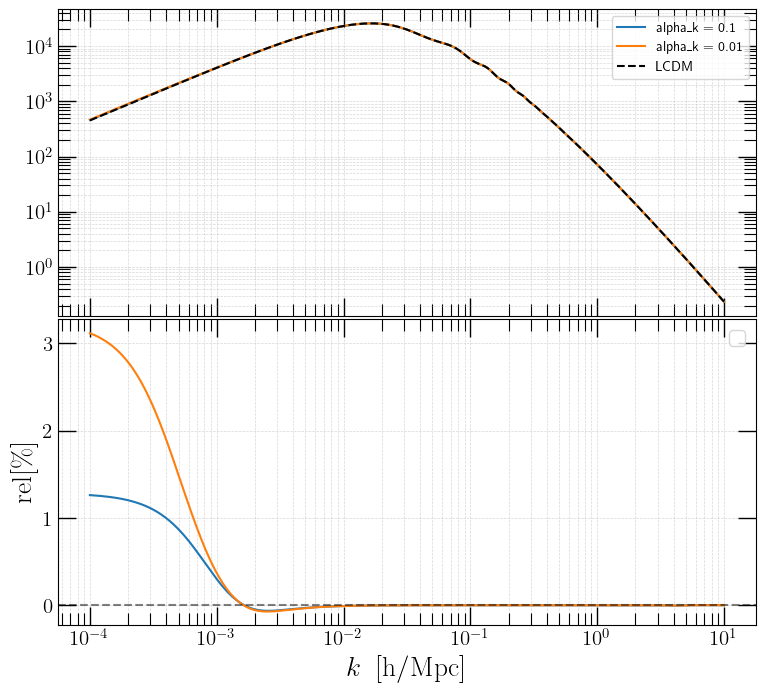

In [17]:
plt.rc("text", usetex=True)
font = {"family": "normal", "size": 15}

cmap = plt.get_cmap('Blues')
blue_colors = [cmap((i + 1) / 6) for i in range(6)]

fig, axs = plt.subplots(2, 1, figsize=(9, 8), sharex=True)
plt.subplots_adjust(hspace=0.012, wspace=0.0)

# ax.plot(k_pi[:460],PP_pi[:460],'o', label = "KGB, $z=100$")


# data["kgb_ev"]["delta"]["z=" + str(redshifts[i])] = np.loadtxt(
#     "./../imp/pk_00" + str(i) + "_delta.dat"
# )
# k = data['kgb_ev']['delta']['z=1'][:,0]
# pk = data['kgb_ev']['delta']['z=1'][:,1]

# Pk_m = []
# for i in range (0,len(k)):
#     Pk_m.append(pk[i]*(2*(np.pi)**2)/((k[i])**3))
    

#     ax[0].plot(k[:460],Pk_m[:460],'o', c = colors[i], label = "KGB, $z=$"+str(redshifts[i]))


axs[0].plot(kk, Pk_alphaK1, linestyle="-", label = "alpha_k = 0.1")
axs[0].plot(kk, Pk_alphaK2, linestyle="-", label = 'alpha_k = 0.01')

axs[1].plot(
    kk,
    ((np.array(Pk_alphaK1) / Pk_LCDM) - 1) * 100,
    linestyle="-"
)
axs[1].plot(
    kk,
    ((np.array(Pk_alphaK2) / Pk_LCDM) - 1) * 100,
    linestyle="-"
)
    

#axs[0].plot(kk, Pk_kess, linestyle="-", color="orange",label="k-essence")

axs[0].plot(kk, Pk_LCDM, linestyle="--", color="black", label="LCDM")   
axs[1].axhline(0, color='black', linestyle='--', alpha= 0.5)

for i in range(2):

    axs[i].tick_params("both", length=13, width=1, which="major")
    axs[i].tick_params("both", length=8.5, width=0.8, which="minor")
    axs[i].tick_params(direction="in", which="major", labelsize=15)
    axs[i].tick_params(direction="in", which="minor")
    axs[i].yaxis.set_ticks_position("both")
    axs[i].xaxis.set_ticks_position("both")
    axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5, alpha=0.5)
    axs[i].legend()

axs[0].set_yscale("log")
axs[1].legend(fontsize=15, ncol=2)

axs[1].set_ylabel(r"${\mathrm{rel}[\%]}$", fontsize=20)
axs[1].set_xlabel(r"$k \,\,\,  \mathrm{[h/Mpc]}$", fontsize=20)

In [19]:
for i in range(np.shape(redshifts)[0]):
    # Format `i` to ensure filenames are correct
    file_index = str(i).zfill(2)  # Pads with one leading zero if `i` is a single digit
    
    data_kev["kev"]["delta"]["z=" + str(redshifts[i])] = np.loadtxt(
        f"./../{folder_name_kev}/pk_0{file_index}_delta.dat"
    )
    k = data_kev["kev"]["delta"]["z=" + str(redshifts[i])][:, 0]
    pk = data_kev["kev"]["delta"]["z=" + str(redshifts[i])][:, 1]

In [20]:
Pk_m = []
for i in range (0,len(k)):
    Pk_m.append(pk[i]*(2*(np.pi)**2)/((k[i])**3))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$k \\,\\,\\,  \\mathrm{[h/Mpc]}$')

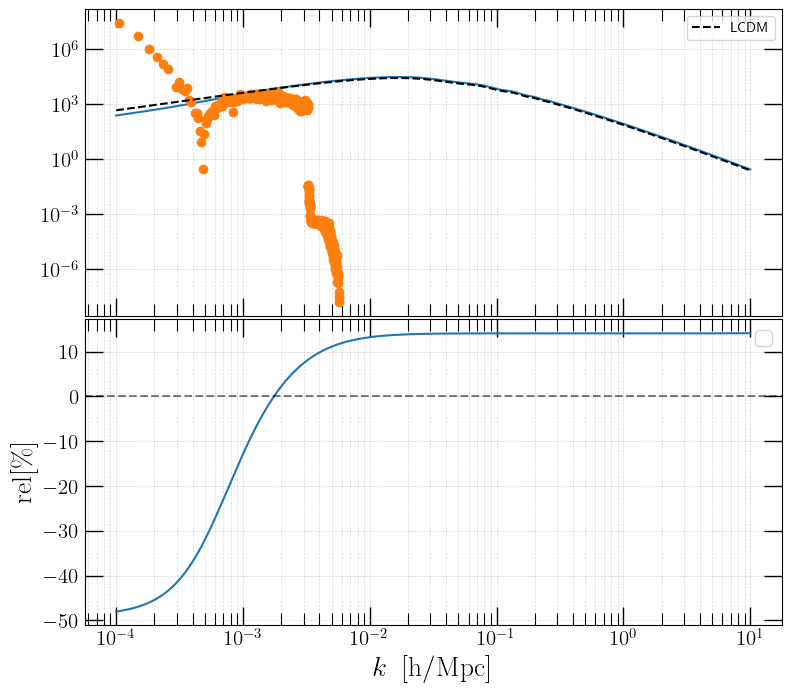

In [21]:
plt.rc("text", usetex=True)
font = {"family": "normal", "size": 15}

cmap = plt.get_cmap('Blues')
blue_colors = [cmap((i + 1) / 6) for i in range(6)]

fig, axs = plt.subplots(2, 1, figsize=(9, 8), sharex=True)
plt.subplots_adjust(hspace=0.012, wspace=0.0)

# ax.plot(k_pi[:460],PP_pi[:460],'o', label = "KGB, $z=100$")


# data["kgb_ev"]["delta"]["z=" + str(redshifts[i])] = np.loadtxt(
#     "./../imp/pk_00" + str(i) + "_delta.dat"
# )
# k = data['kgb_ev']['delta']['z=1'][:,0]
# pk = data['kgb_ev']['delta']['z=1'][:,1]

# Pk_m = []
# for i in range (0,len(k)):
#     Pk_m.append(pk[i]*(2*(np.pi)**2)/((k[i])**3))
    

#     ax[0].plot(k[:460],Pk_m[:460],'o', c = colors[i], label = "KGB, $z=$"+str(redshifts[i]))


axs[0].plot(kk, Pk_alphaB, linestyle="-")
axs[0].plot(k, Pk_m, "o")

axs[1].plot(
    kk,
    ((np.array(Pk_alphaB) / Pk_LCDM) - 1) * 100,
    linestyle="-"
)

    

#axs[0].plot(kk, Pk_kess, linestyle="-", color="orange",label="k-essence")

axs[0].plot(kk, Pk_LCDM, linestyle="--", color="black", label="LCDM")   
axs[1].axhline(0, color='black', linestyle='--', alpha= 0.5)

for i in range(2):

    axs[i].tick_params("both", length=13, width=1, which="major")
    axs[i].tick_params("both", length=8.5, width=0.8, which="minor")
    axs[i].tick_params(direction="in", which="major", labelsize=15)
    axs[i].tick_params(direction="in", which="minor")
    axs[i].yaxis.set_ticks_position("both")
    axs[i].xaxis.set_ticks_position("both")
    axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5, alpha=0.5)
    axs[i].legend()

axs[0].set_yscale("log")
axs[1].legend(fontsize=15, ncol=2)

axs[1].set_ylabel(r"${\mathrm{rel}[\%]}$", fontsize=20)
axs[1].set_xlabel(r"$k \,\,\,  \mathrm{[h/Mpc]}$", fontsize=20)